# INTRODUCTION

 This project explores data from the “Pet Adoption Records with Animal & Adopter Data” dataset by @Sanika Chaudhari, which includes detailed information about pets available for adoption and the people who adopt them.
 The work was divided into four main parts:
1. **Data Cleaning and Preparation:** The raw dataset was reviewed and cleaned to ensure consistency and accuracy. This included handling missing values, standardizing categories (such as date values, and gender), and preparing the data for analysis and modeling.
2. **Dashboard Development:** After preparing the data, a Looker Studio dashboard was created to provide a visual summary of the adoption center’s pet profiles. It highlights key metrics such as the distribution of animal types, colors, genders, and adoption status, allowing for quick and interactive exploration.
3. **Exploratory Data Analysis:** With the help of SQL queries, we analyzed patterns and relationships between animal characteristics and adopter information. This step helped identify trends and potential factors that may affect the likelihood of adoption.
4. **Predictive Modeling:** A machine learning model was built to estimate the probability that an animal will be adopted, based on its characteristics.

In [1]:
# LIBRARY IMPORT

# base
import os
import pandas as pd
import numpy as np

# import
import kagglehub
from kagglehub import KaggleDatasetAdapter

# visual
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import IFrame
from IPython.display import display, Image, Markdown

# statistical
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
import graphviz
from sklearn import tree
from sklearn import datasets, svm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

# data type
from datetime import datetime
!pip install gender-guesser --user
import sys
sys.path.append('/root/.local/lib/python3.11/site-packages')
import gender_guesser.detector as gender

# SQL 
import duckdb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 379.3/379.3 kB 6.7 MB/s eta 0:00:00


# DATA LOADING, CLEANING, AND PREPARATION

In [2]:
# loading the dataset

file_path = 'pet_adoption_center.csv'

df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "chaudharisanika/pet-adoption-records-with-animal-and-adopter-data", file_path)

df.head()

/tmp/ipykernel_13/2965200857.py:5: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "chaudharisanika/pet-adoption-records-with-animal-and-adopter-data", file_path)


,pet_id,pet_name,species,breed,age_years,gender,color,arrival_date,adopted,adoption_date,adopter_id,adopter_name,adopter_age,adopter_city,adopter_previous_pets
0,P0001,Sandra,Dog,Yorkshire Terrier,2,Female,White,2024-10-10,True,2025-03-11,A0001,Megan Rogers,56,Mcgeestad,1
1,P0002,Brian,Cat,Tonkinese,1,Female,Golden,2023-09-09,True,2024-02-10,A0002,Jonathan Hawkins,18,Geneshire,2
2,P0003,Timothy,Bird,Amazon Parrot,4,Male,Spotted,2023-10-03,False,2023-10-17,NaN,NaN,-1,NaN,0
3,P0004,Karl,Dog,German Shepherd,1,Female,White,2024-07-28,True,2024-08-12,A0004,Natalie Rivera,51,North Richard,3
4,P0005,Sarah,Rabbit,Dutch,1,Female,Spotted,2024-02-21,False,2024-02-26,NaN,NaN,-1,NaN,0


In [3]:
# dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   pet_id                 200 non-null    object
 1   pet_name               200 non-null    object
 2   species                200 non-null    object
 3   breed                  200 non-null    object
 4   age_years              200 non-null    int64 
 5   gender                 200 non-null    object
 6   color                  200 non-null    object
 7   arrival_date           200 non-null    object
 8   adopted                200 non-null    bool  
 9   adoption_date          200 non-null    object
 10  adopter_id             118 non-null    object
 11  adopter_name           118 non-null    object
 12  adopter_age            200 non-null    int64 
 13  adopter_city           118 non-null    object
 14  adopter_previous_pets  200 non-null    int64 
dtypes: bool(1), int64(3), o

In [4]:
df.isnull().sum()

pet_id                    0
pet_name                  0
species                   0
breed                     0
age_years                 0
gender                    0
color                     0
arrival_date              0
adopted                   0
adoption_date             0
adopter_id               82
adopter_name             82
adopter_age               0
adopter_city             82
adopter_previous_pets     0
dtype: int64

The null values present in the dataset are exclusively related to adopter information. Therefore, they were not handled or removed, as they do not impact the core analysis focused on the animals themselves.

In [5]:
# DATA CLEANING

# DATE COLUMNS:
# converting date columns into datetime values

df['arrival_date'] = pd.to_datetime(df['arrival_date'], format = '%Y-%m-%d')
df['adoption_date'] = pd.to_datetime(df['adoption_date'], format = '%Y-%m-%d')

# creation of time_in_shelter column

df['time_in_shelter'] = np.where(df['adopted'] == True, df['adoption_date'] - df['arrival_date'], datetime.now() - df['arrival_date'])
df['time_in_shelter'] = df['time_in_shelter'].dt.days


To properly analyze the adopter's profile, we will use [gender-guesser](https://pypi.org/project/gender-guesser/), a Python package that estimates the gender of a forename based on the likelihood of it being male, female, mostly_male, mostly_female, or unknown.

In [6]:
# ADOPTER DATA:

# 1. Removing pronouns: some individuals include pronouns before their first name, which causes gender-guesser to return an 'unknown' result.
df['adopter_name'] = df['adopter_name'].replace(['Mr. ', 'Mrs. ', ' MD'], '', regex=True)

# 2. spliting columns 'adopter_name' into firs and last name: 
df[['adopter_first_name', 'adopter_last_name']] = df['adopter_name'].str.split(' ', n=1,  expand=True)

# 3. DETERMINING ADOPTER GENDER WITH GENDER-GUESSER

d = gender.Detector()

df['adopter_gender'] = df['adopter_first_name'].apply(lambda x: d.get_gender(x))

# The gender-guesser categorizes as 'mostly_male' and 'mostly_female'. For practical reasons, we will simplify these to 'male' and 'female'
df['adopter_gender'] = df['adopter_gender'].replace(['mostly_male', 'mostly_female'], ['male', 'female'])

# For consistency, we will capitalize 'adopter_gender'
df['adopter_gender'] = df['adopter_gender'].str.capitalize()

In [7]:
df.head()

,pet_id,pet_name,species,breed,age_years,gender,color,arrival_date,adopted,adoption_date,adopter_id,adopter_name,adopter_age,adopter_city,adopter_previous_pets,time_in_shelter,adopter_first_name,adopter_last_name,adopter_gender
0,P0001,Sandra,Dog,Yorkshire Terrier,2,Female,White,2024-10-10,True,2025-03-11,A0001,Megan Rogers,56,Mcgeestad,1,152,Megan,Rogers,Female
1,P0002,Brian,Cat,Tonkinese,1,Female,Golden,2023-09-09,True,2024-02-10,A0002,Jonathan Hawkins,18,Geneshire,2,154,Jonathan,Hawkins,Male
2,P0003,Timothy,Bird,Amazon Parrot,4,Male,Spotted,2023-10-03,False,2023-10-17,NaN,NaN,-1,NaN,0,657,NaN,NaN,Unknown
3,P0004,Karl,Dog,German Shepherd,1,Female,White,2024-07-28,True,2024-08-12,A0004,Natalie Rivera,51,North Richard,3,15,Natalie,Rivera,Female
4,P0005,Sarah,Rabbit,Dutch,1,Female,Spotted,2024-02-21,False,2024-02-26,NaN,NaN,-1,NaN,0,516,NaN,NaN,Unknown


In [8]:
# Now that we have determined the gender, we can remove the names columns. We also removed the city column, as it is not relevant to the analysis.
df = df.drop(columns=['adopter_first_name', 'adopter_last_name', 'adopter_city', 'adopter_name'])

In [9]:
# Dataset column reorganization
df = df[[
    'pet_id',
    'pet_name',
    'species',
    'breed',
    'age_years',
    'gender',
    'color',
    'arrival_date',
    'adoption_date',
    'time_in_shelter',
    'adopted',
    'adopter_id',
    'adopter_age',
    'adopter_gender',
    'adopter_previous_pets'
    ]]

df.head()

,pet_id,pet_name,species,breed,age_years,gender,color,arrival_date,adoption_date,time_in_shelter,adopted,adopter_id,adopter_age,adopter_gender,adopter_previous_pets
0,P0001,Sandra,Dog,Yorkshire Terrier,2,Female,White,2024-10-10,2025-03-11,152,True,A0001,56,Female,1
1,P0002,Brian,Cat,Tonkinese,1,Female,Golden,2023-09-09,2024-02-10,154,True,A0002,18,Male,2
2,P0003,Timothy,Bird,Amazon Parrot,4,Male,Spotted,2023-10-03,2023-10-17,657,False,NaN,-1,Unknown,0
3,P0004,Karl,Dog,German Shepherd,1,Female,White,2024-07-28,2024-08-12,15,True,A0004,51,Female,3
4,P0005,Sarah,Rabbit,Dutch,1,Female,Spotted,2024-02-21,2024-02-26,516,False,NaN,-1,Unknown,0


# PET ADOPTION CENTER (LOOKER STUDIO DASHBOARD)

In the following dashboard, we can see the main characteristics of the pet center: the number of animals by species, the most popular breeds and coat colors, and the timeline of adoptions versus arrivals. We can also see that 118 animals have been adopted and that, on average, an animal spends 186.3 days in the shelter.

In [10]:
dashboard = IFrame(
    src="https://lookerstudio.google.com/embed/reporting/ea0420cb-8711-4613-988e-f57f0f02f096/page/IrsRF",
    width=800,
    height=600
)

dashboard.allow_fullscreen = True
dashboard.sandbox = [
    "allow-storage-access-by-user-activation",
    "allow-scripts",
    "allow-same-origin",
    "allow-popups",
    "allow-popups-to-escape-sandbox"
]

dashboard

# EXPLORING ADOPTER'S AND PETS PROFILE WITH SQL

To run SQL queries in the notebook, we will use [DuckDB](http://duckdb.org/docs/stable/clients/python/overview.html), an embedded analytical database engine optimized for OLAP workloads and designed to efficiently query large datasets directly within Python environments.

**1. ADOPTERS:**
We found an equal number of male and female adopters (59 each). On average, adopters are in their late forties and have previously owned more than two pets.



In [11]:
# 1. Adopter's profile: AVERAGE AGE and PREVIOUS PETS grouped by GENDER

adopter_profile = duckdb.sql("SELECT adopter_gender, COUNT(*) AS adopter_count, AVG(adopter_age) AS avg_adopter_age, AVG(adopter_previous_pets) AS avg_previous_pets FROM df WHERE adopted='True' GROUP BY adopter_gender").to_df()
adopter_profile[['avg_adopter_age', 'avg_previous_pets']] = adopter_profile[['avg_adopter_age', 'avg_previous_pets']].round(2)
adopter_profile

,adopter_gender,adopter_count,avg_adopter_age,avg_previous_pets
0,Female,59,49.63,2.42
1,Male,59,46.10,2.54


**2. ANIMAL'S:**
The animals that were adopted are around 7 years old (except for rabbits, which are over 8), and they spent approximately 70 to 80 days in the shelter. In contrast, the pets that weren't adopted are slightly younger, lthough hamsters show an average age of 9 years (which likely indicates a data error, as their typical lifespan is only 2 to 3 years). The animals currently in the shelter have been there for over a year.


In [12]:
adopted_pet_profile = duckdb.sql("SELECT species, COUNT(*) AS adopted_count, AVG(age_years) AS avg_age, AVG(time_in_shelter) AS avg_time_in_shelter FROM df WHERE adopted='True' GROUP BY species").to_df()
adopted_pet_profile[['avg_age', 'avg_time_in_shelter']] = adopted_pet_profile[['avg_age', 'avg_time_in_shelter']].round(2)
adopted_pet_profile

,species,adopted_count,avg_age,avg_time_in_shelter
0,Bird,25,7.36,80.52
1,Cat,25,7.56,89.64
2,Dog,27,7.30,74.96
3,Hamster,24,7.54,73.00
4,Rabbit,17,8.06,82.18


In [13]:
shelter_pet_profile = duckdb.sql("SELECT species, COUNT(*) AS adopted_count, AVG(age_years) AS avg_age, AVG(time_in_shelter) AS avg_time_in_shelter FROM df WHERE adopted='False' GROUP BY species").to_df()
shelter_pet_profile[['avg_age', 'avg_time_in_shelter']] = shelter_pet_profile[['avg_age', 'avg_time_in_shelter']].round(2)
shelter_pet_profile

,species,adopted_count,avg_age,avg_time_in_shelter
0,Cat,20,7.20,374.70
1,Rabbit,15,7.20,395.67
2,Dog,16,7.50,282.62
3,Hamster,20,9.00,318.30
4,Bird,11,6.27,342.64


# PREDICTIVE MODEL:

The shelter is promoting an adoption event today! Among all the adorable pets looking for a home is Lily, a small black cat who arrived just last week. With this model, we aim to estimate whether Lily has a chance of leaving the shelter for a new, loving home.

![lily_pet_id](https://raw.githubusercontent.com/marinafso/pet_adoption_database_project/refs/heads/main/LILY%20PET%20ID.png)

Photo by <a href="https://unsplash.com/@antonnpo?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Anton Ponomarenko</a> on <a href="https://unsplash.com/photos/black-cat-on-white-floor-j7uVTlpwI0o?utm_content=creditCopyText&utm_medium=referral&utm_source=unsplash">Unsplash</a>
      

In [14]:
# data preparation

df_adoption_analysis = df[['adopted', 'species', 'color', 'age_years', 'time_in_shelter', 'gender']]
df_adoption_analysis.head()

,adopted,species,color,age_years,time_in_shelter,gender
0,True,Dog,White,2,152,Female
1,True,Cat,Golden,1,154,Female
2,False,Bird,Spotted,4,657,Male
3,True,Dog,White,1,15,Female
4,False,Rabbit,Spotted,1,516,Female


In [15]:
# CATEGORICAL VARIABLES

## NOMINAL

### species
df_adoption_analysis.loc[:, 'species_dog_nom'] = df_adoption_analysis['species'].apply(lambda species: 1 if species == 'Dog' else 0)
df_adoption_analysis.loc[:, 'species_cat_nom'] = df_adoption_analysis['species'].apply(lambda species: 1 if species == 'Cat' else 0)
df_adoption_analysis.loc[:, 'species_bird_nom'] = df_adoption_analysis['species'].apply(lambda species: 1 if species == 'Bird' else 0)
df_adoption_analysis.loc[:, 'species_rabbit_nom'] = df_adoption_analysis['species'].apply(lambda species: 1 if species == 'Rabbit' else 0)
df_adoption_analysis.loc[:, 'species_hamster_nom'] = df_adoption_analysis['species'].apply(lambda species: 1 if species == 'Hamster' else 0)

### gender
df_adoption_analysis.loc[:, 'gender_male_nom'] = df_adoption_analysis['gender'].apply(lambda gender: 1 if gender == 'Male' else 0)
df_adoption_analysis.loc[:, 'gender_female_nom'] = df_adoption_analysis['gender'].apply(lambda gender: 1 if gender == 'Female' else 0)

### color
df_adoption_analysis.loc[:, 'color_golden_nom'] = df_adoption_analysis['color'].apply(lambda color: 1 if color == 'Golden' else 0)
df_adoption_analysis.loc[:, 'color_spotted_nom'] = df_adoption_analysis['color'].apply(lambda color: 1 if color == 'Spotted' else 0)
df_adoption_analysis.loc[:, 'color_mixed_nom'] = df_adoption_analysis['color'].apply(lambda color: 1 if color == 'Mixed' else 0)
df_adoption_analysis.loc[:, 'color_brown_nom'] = df_adoption_analysis['color'].apply(lambda color: 1 if color == 'Brown' else 0)
df_adoption_analysis.loc[:, 'color_black_nom'] = df_adoption_analysis['color'].apply(lambda color: 1 if color == 'Black' else 0)
df_adoption_analysis.loc[:, 'color_white_nom'] = df_adoption_analysis['color'].apply(lambda color: 1 if color == 'White' else 0)
df_adoption_analysis.loc[:, 'color_grey_nom'] = df_adoption_analysis['color'].apply(lambda color: 1 if color == 'Grey' else 0)

/tmp/ipykernel_13/648398518.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adoption_analysis.loc[:, 'species_dog_nom'] = df_adoption_analysis['species'].apply(lambda species: 1 if species == 'Dog' else 0)
/tmp/ipykernel_13/648398518.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_adoption_analysis.loc[:, 'species_cat_nom'] = df_adoption_analysis['species'].apply(lambda species: 1 if species == 'Cat' else 0)
/tmp/ipykernel_13/648398518.py:8: SettingWithCopyWarning: 
A value is trying to be set

In [16]:
df_adoption_analysis.head()

,adopted,species,color,age_years,time_in_shelter,gender,species_dog_nom,species_cat_nom,species_bird_nom,species_rabbit_nom,species_hamster_nom,gender_male_nom,gender_female_nom,color_golden_nom,color_spotted_nom,color_mixed_nom,color_brown_nom,color_black_nom,color_white_nom,color_grey_nom
0,True,Dog,White,2,152,Female,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,True,Cat,Golden,1,154,Female,0,1,0,0,0,0,1,1,0,0,0,0,0,0
2,False,Bird,Spotted,4,657,Male,0,0,1,0,0,1,0,0,1,0,0,0,0,0
3,True,Dog,White,1,15,Female,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,False,Rabbit,Spotted,1,516,Female,0,0,0,1,0,0,1,0,1,0,0,0,0,0


In [17]:
df_adoption_analysis = df_adoption_analysis.drop(columns=['species', 'gender', 'color'])
df_adoption_analysis.head()

,adopted,age_years,time_in_shelter,species_dog_nom,species_cat_nom,species_bird_nom,species_rabbit_nom,species_hamster_nom,gender_male_nom,gender_female_nom,color_golden_nom,color_spotted_nom,color_mixed_nom,color_brown_nom,color_black_nom,color_white_nom,color_grey_nom
0,True,2,152,1,0,0,0,0,0,1,0,0,0,0,0,1,0
1,True,1,154,0,1,0,0,0,0,1,1,0,0,0,0,0,0
2,False,4,657,0,0,1,0,0,1,0,0,1,0,0,0,0,0
3,True,1,15,1,0,0,0,0,0,1,0,0,0,0,0,1,0
4,False,1,516,0,0,0,1,0,0,1,0,1,0,0,0,0,0


In [18]:
# train/test
predictors_train, predictors_test, target_train, target_test = train_test_split(
    df_adoption_analysis.drop(['adopted'], axis=1),
    df_adoption_analysis['adopted'],
    test_size=0.333,
    random_state=123
)

print(f'predictors_train.shape = {predictors_train.shape}')
print(f'predictors_test.shape = {predictors_test.shape}')
print(f'target_train.shape = {target_train.shape}')
print(f'target_test.shape = {target_test.shape}')

predictors_train.shape = (133, 16)
predictors_test.shape = (67, 16)
target_train.shape = (133,)
target_test.shape = (67,)


In [19]:
# modeling

## train
model = DecisionTreeClassifier()

model = model.fit(predictors_train, target_train)

model.__dict__

{'criterion': 'gini',
 'splitter': 'best',
 'max_depth': None,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.0,
 'max_features': None,
 'max_leaf_nodes': None,
 'random_state': None,
 'min_impurity_decrease': 0.0,
 'class_weight': None,
 'ccp_alpha': 0.0,
 'feature_names_in_': array(['age_years', 'time_in_shelter', 'species_dog_nom',
        'species_cat_nom', 'species_bird_nom', 'species_rabbit_nom',
        'species_hamster_nom', 'gender_male_nom', 'gender_female_nom',
        'color_golden_nom', 'color_spotted_nom', 'color_mixed_nom',
        'color_brown_nom', 'color_black_nom', 'color_white_nom',
        'color_grey_nom'], dtype=object),
 'n_features_in_': 16,
 'n_outputs_': 1,
 'classes_': array([False,  True]),
 'n_classes_': 2,
 'max_features_': 16,
 'tree_': <sklearn.tree._tree.Tree at 0x7d1ea8082800>}

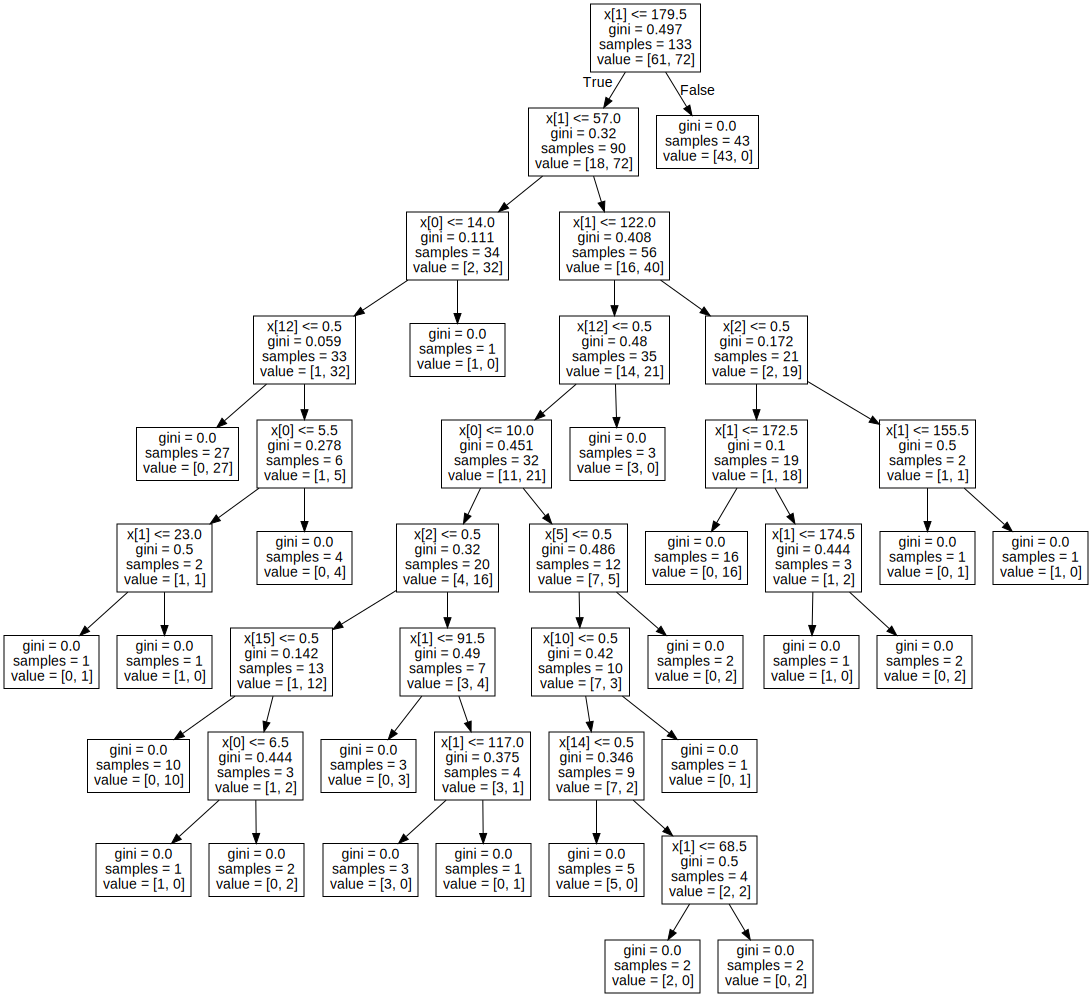

In [20]:
### decision tree

tree_data = tree.export_graphviz(model, out_file=None)
graph = graphviz.Source(tree_data)
graph

In [21]:
## confusion matrix

target_predicted = model.predict(predictors_test)

confusion_matrix = confusion_matrix(target_test, target_predicted)
print(confusion_matrix)

[[19  2]
 [17 29]]


In [22]:
x_test = predictors_test
y_test = target_test

x_train = predictors_train
y_train = target_train

classifier = svm.SVC(kernel="linear", C=0.01).fit(x_train, y_train)

class_names = model.classes_
print(class_names)

[False  True]


[[18  3]
 [ 0 46]]


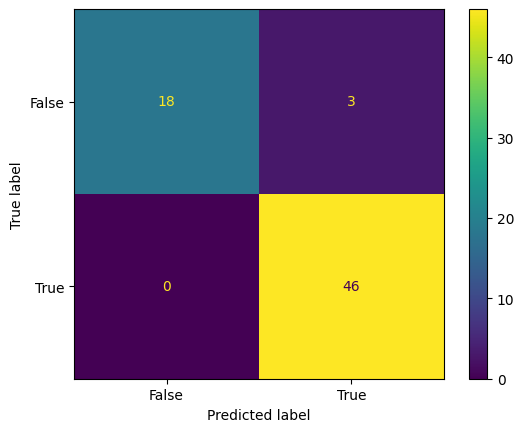

In [23]:
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        x_test,
        y_test,
        display_labels=class_names,

    )

print(disp.confusion_matrix)

plt.show()

In [24]:
## accuracy

accuracy = accuracy_score(target_test, target_predicted)
print(f"Accuracy: {accuracy * 100:.2f}%")  

Accuracy: 71.64%


In [25]:
# prediction

collumn_names = [
    'age_years', 'time_in_shelter', 'species_dog_nom', 'species_cat_nom',
    'species_bird_nom', 'species_rabbit_nom', 'species_hamster_nom',
    'gender_male_nom', 'gender_female_nom',
    'color_golden_nom', 'color_spotted_nom', 'color_mixed_nom',
    'color_brown_nom', 'color_black_nom', 'color_white_nom', 'color_grey_nom'
]

lily = np.array([3,7,0,1,0,0,0,0,1,0,0,0,0,1,0,0])

lily_df = pd.DataFrame([lily], columns=collumn_names)

lily_df

,age_years,time_in_shelter,species_dog_nom,species_cat_nom,species_bird_nom,species_rabbit_nom,species_hamster_nom,gender_male_nom,gender_female_nom,color_golden_nom,color_spotted_nom,color_mixed_nom,color_brown_nom,color_black_nom,color_white_nom,color_grey_nom
0,3,7,0,1,0,0,0,0,1,0,0,0,0,1,0,0


In [26]:
adoption_status = model.predict(lily_df)

if adoption_status[0]:
    display(Markdown("Congrats! Lily got a new home!"))
    display(Image(url="https://raw.githubusercontent.com/marinafso/pet_adoption_database_project/refs/heads/main/Screenshot%202025-07-18%20at%2021-30-31%20lily_adopted.png%20(imagem%20PNG%201024%20%C3%97%201536%20pixels)%20-%20Redimensionada%20(48%25).png")) 
else:
    print('Sorry, Lily will go back to the shelter. :(')

Congrats! Lily got a new home!